# MHEALTH 데이터셋 이해하기
***
1. 데이터셋 구조
    - 피험자별 로그 파일: 각 피험자의 데이터는 `mHealth_subject<SUBJECT_ID>.log` 파일에 저장되어 있음
    - **샘플과 센서 데이터**: 각 파일은 시간 순서대로 기록된 센서 데이터(행)와 각 센서별 측정값(열)을 포함
    - **레이블**: 24번째 열은 활동 레이블을 나타내며, '0'은 null 클래스를 의미

2. 센서 데이터
    - 흉부 센서: 가속도계 (X, Y, Z)
    - 심전도(ECG): 리드 1, 리드 2
    - 좌측 발목 센서: 가속도계, 자이로스코프, 자력계 (각각 X, Y, Z 축)
    - 우측 하완 센서(손목 센서로 간주): 가속도계, 자이로스코프, 자력계 (각각 X, Y, Z 축)

3. 활동 레이블
    1. `0`: null 클래스
    2. `1`: 앉기 (Standing still)
    3. `2`: 걷기
    4. `3`: 계단 오르기
    5. `4`: 계단 내리기
    6. `5`: 달리기
    7. `6`: 운동 (cycling)
    8. `7`: 조깅
    9. `8`: 점핑 잭 (jumping)
    10. `9`: 로프 스킵 (rope jumping)

# 목차
1. 라이브러리 임포트 및 설정
2. 슬라이딩 윈도우 함수 정의
3. 특성 추출 함수 정의
4. 데이터 증강 함수 정의
5. MHEALTH 데이터 로드 및 전처리
    - 데이터 로드
    - 슬라이딩 윈도우 적용 및 특성 추출
    - 데이터 증강
    - 데이터 스케일링
6. 데이터셋 분할 및 시퀀스 생성
7. 데이터셋 및 데이터로더 생성
8. CNN-LSTM 모델 정의
9. 모델 학습
10. 모델 평가
    - 혼동 행렬 및 분류 보고서 출력
11. 마무리

# 1. 필요한 라이브러리 임포트

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pywt

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 중인 디바이스: {device}")
if device.type == 'cuda':
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")

사용 중인 디바이스: cuda
GPU 이름: NVIDIA GeForce GTX 1650


# 2. 슬라이딩 윈도우 함수 정의

In [2]:
def sliding_window(data, window_size, step_size):
    """
    슬라이딩 윈도우를 적용하여 데이터를 윈도우로 분할합니다.

    Parameters:
        data (numpy array): 입력 데이터 (samples, channels).
        window_size (int): 윈도우 크기.
        step_size (int): 윈도우 이동 크기.

    Returns:
        numpy array: 윈도우로 분할된 데이터 (num_windows, window_size, channels).
    """
    
    num_samples = data.shape[0]
    
    if num_samples < window_size:
        return np.array([])  # 빈 배열 반환
        
    windows = []
    
    for start in range(0, num_samples - window_size + 1, step_size):
        end = start + window_size
        window = data[start:end, :]
        windows.append(window)
        
    return np.array(windows)

# 3. 특성 추출 함수 정의

In [3]:
def extract_features(windows):
    """
    각 윈도우에 대해 특성을 추출합니다.

    Parameters:
        windows (numpy array): 윈도우로 분할된 데이터 (num_windows, window_size, channels).

    Returns:
        numpy array: 추출된 특성 (num_windows, num_features).
    """
    
    features = []
    
    for window in windows:
        window_features = []
        
        if window.ndim == 1:
            window = window[:, np.newaxis]
            
        num_channels = window.shape[1]
        
        for channel in range(num_channels):
            signal = window[:, channel]
            
            # 기본 통계량
            mean = np.mean(signal)
            std = np.std(signal)
            skewness = stats.skew(signal)
            kurtosis = stats.kurtosis(signal)
            rms = np.sqrt(np.mean(signal**2))
            
            # FFT
            fft_coeffs = np.fft.rfft(signal)
            fft_mean = np.mean(np.abs(fft_coeffs))
            fft_std = np.std(np.abs(fft_coeffs))
            
            # 웨이블릿 변환 후 에너지
            coeffs = pywt.wavedec(signal, 'db1', level=3)
            energy = sum([np.sum(c**2) for c in coeffs])
            
            # 특성 벡터에 추가
            window_features.extend([mean, std, skewness, kurtosis, rms, fft_mean, fft_std, energy])
            
        features.append(window_features)
    return np.array(features)


# 4. 데이터 증강 함수 정의

In [4]:
def augment_data(X, y):
    """
    데이터 증강을 위해 가우시안 노이즈를 추가합니다.

    Parameters:
        X (numpy array): 입력 데이터.
        y (numpy array): 레이블.

    Returns:
        tuple: 증강된 데이터와 레이블.
    """
    
    noise = np.random.normal(0, 0.01, X.shape)
    X_augmented = X + noise
    y_augmented = y.copy()
    
    return X_augmented, y_augmented

# 5. MHEALTH 데이터 로드 및 전처리
***
## 5.1 데이터 로드

In [5]:
# 데이터 파일 경로 설정
data_files = glob.glob(r'C:/AI/data/MHEALTHDATASET/mHealth_subject*.log')

# 데이터와 레이블을 저장할 리스트 초기
X_list = []
y_list = []

for file in data_files:
    data = pd.read_csv(file, sep='\s+', header=None)
    print(f"파일명: {file}")
    print(f"data.shape: {data.shape}")

    # 데이터의 열 수가 24개인지 확인
    if data.shape[1] != 24:
        print(f"데이터의 열 수가 24가 아닙니다. 파일을 확인하세요.")
        continue  # 다음 파일로 넘어감
        
    # 우측 하완 센서의 가속도계 데이터 추출 (열 15~17)
    # right_arm_accel = data.iloc[:, 14:17].values  # 열 15~17 (Python 인덱스는 0부터 시작)
    
     # 우측 하완 센서의 자이로스코프 데이터 추출 (열 18~20)
    right_arm_gyro = data.iloc[:, 17:20].values   # 열 18~20
    # 필요한 경우 자력계 데이터(열 21~23)도 포함 가능
    
    # 센서 데이터를 결합
    # sensor_data = np.hstack((right_arm_accel, right_arm_gyro))
    
    # 레이블 추출 (열 24)
    labels = data.iloc[:, 23].values  # 열 24
    
    # null 클래스(레이블 0)는 제외하거나 필요에 따라 처리
    valid_indices = labels != 0
    sensor_data = right_arm_gyro[valid_indices, :]
    labels = labels[valid_indices]
    
    # 데이터와 레이블 저장
    X_list.append(sensor_data)
    y_list.append(labels)

print(f"MHEALTH_DataSet 자이로스코프:\n{X_list}")
print(f"MHEALTH_DataSet 레이블:\n{y_list}")

파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject1.log
data.shape: (161280, 24)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject10.log
data.shape: (98304, 24)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject2.log
data.shape: (130561, 24)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject3.log
data.shape: (122112, 24)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject4.log
data.shape: (116736, 24)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject5.log
data.shape: (119808, 24)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject6.log
data.shape: (98304, 24)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject7.log
data.shape: (104448, 24)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject8.log
data.shape: (129024, 24)
파일명: C:/AI/data/MHEALTHDATASET\mHealth_subject9.log
data.shape: (135168, 24)
MHEALTH_DataSet 자이로스코프:
[array([[-0.058824, -0.93429 , -0.34483 ],
       [-0.058824, -0.93429 , -0.34483 ],
       [-0.058824, -0.93429 , -0.34483 ],
       ...,
       [-1.102   , -0.47433 , -0.38362 ],
       [-1.102   , -0.4743

- `data.shape`: (161,280, 24)
    - 데이터 파일이 올바르게 읽혀졌으며, 24개의 열을 가지고 있습니다.
- `right_arm_gyro.shape`: (161,280, 3)
    - 우측 하완 센서의 자이로스코프 데이터가 올바르게 추출되었습니다.
- `labels.shape`: (161,280,)
    - 레이블 데이터도 올바르게 추출되었습니다.
- `valid_indices.shape`: (161,280,)
    - 레이블이 0이 아닌 샘플을 식별하는 부울 배열입니다.
- `sensor_data.shape after indexing`: (35,174, 3)
    - 레이블이 0이 아닌 샘플의 자이로스코프 데이터가 올바르게 인덱싱되었습니다.
- `labels.shape after indexing`: (35,174,)
    - 인덱싱 후 레이블의 크기도 일치합니다.

## 5.2 데이터 결합

In [6]:
# 리스트를 배열로 변환
X_raw = np.vstack(X_list)
y_raw = np.hstack(y_list)

# 레이블을 0부터 시작하도록 조정
y_raw = y_raw - 1  # 레이블이 1부터 시작하므로 0부터 시작하도록 조정

print("전체 데이터 크기:", X_raw.shape)
print("전체 레이블 크기:", y_raw.shape)

전체 데이터 크기: (343195, 3)
전체 레이블 크기: (343195,)


- 모든 파일에서 추출한 데이터를 하나의 배열로 결합합니다.
- 레이블을 0부터 시작하도록 조정합니다.

## 5.3 슬라이딩 윈도우 적용 및 특성 추출

In [7]:
# 윈도우 설정
window_size = 128  # 샘플 수에 따라 조정 가능
step_size = 64

# 슬라이딩 윈도우 적용
windows = sliding_window(X_raw, window_size, step_size)
labels = sliding_window(y_raw.reshape(-1, 1), window_size, step_size)

# 각 윈도우의 레이블은 가장 많이 등장하는 레이블로 설정
window_labels = [np.bincount(label_window.flatten().astype(int)).argmax() for label_window in labels]

# 특성 추출
X_features = extract_features(windows)
y_labels = np.array(window_labels)

print("윈도우 개수:", X_features.shape[0])
print("추출된 특성의 수:", X_features.shape[1])

윈도우 개수: 5361
추출된 특성의 수: 24


- 슬라이딩 윈도우를 적용하여 데이터를 분할합니다.
- 각 윈도우에서 가장 많이 등장하는 레이블을 해당 윈도우의 레이블로 설정합니다.
- 각 윈도우에 대해 특성을 추출합니다.

## 5.4 데이터 증강

In [8]:
# 데이터 증강 적용
X_augmented, y_augmented = augment_data(X_features, y_labels)

# 원본 데이터와 증강된 데이터 결합
X_combined = np.vstack((X_features, X_augmented))
y_combined = np.hstack((y_labels, y_augmented))

print("증강 후 데이터 크기:", X_combined.shape)

증강 후 데이터 크기: (10722, 24)


## 5.5 데이터 스케일링

In [9]:
# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# 스케일러 저장
joblib.dump(scaler, 'scaler_mhealth_gyro.pkl')

['scaler_mhealth_gyro.pkl']

# 6. 데이터셋 분할 및 시퀀스 생성
***
## 6.1 데이터셋 분할

In [10]:
# 데이터셋 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled,
    y_combined,
    test_size=0.2,
    random_state=42,
    stratify=y_combined
)

print("학습 데이터 크기:", X_train.shape)
print("검증 데이터 크기:", X_val.shape)

학습 데이터 크기: (8577, 24)
검증 데이터 크기: (2145, 24)


## 6.2 시퀀스 생성

In [11]:
# 시퀀스 길이 설정
seq_len = 5  # 원하는 시퀀스 길이로 설정

def create_sequences(features, labels, seq_len):
    sequences = []
    sequence_labels = []
    
    for i in range(len(features) - seq_len + 1):
        seq = features[i:i+seq_len]
        label = labels[i + seq_len - 1]
        sequences.append(seq)
        sequence_labels.append(label)
        
    return np.array(sequences), np.array(sequence_labels)

# 학습 및 검증 데이터에 시퀀스 생성
X_train_seq, y_train_seq = create_sequences(X_train,
                                            y_train,
                                            seq_len)
X_val_seq, y_val_seq = create_sequences(X_val,
                                        y_val,
                                        seq_len)

print("시퀀스 생성 후 학습 데이터 크기:", X_train_seq.shape)
print("시퀀스 생성 후 검증 데이터 크기:", X_val_seq.shape)

시퀀스 생성 후 학습 데이터 크기: (8573, 5, 24)
시퀀스 생성 후 검증 데이터 크기: (2141, 5, 24)


# 7. 데이터셋 및 데이터로더 생성

In [12]:
class ActivityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 데이터셋 생성
train_dataset = ActivityDataset(X_train_seq,
                                y_train_seq)
val_dataset = ActivityDataset(X_val_seq,
                              y_val_seq)

# 데이터로더 생성
batch_size = 64
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

# 8. CNN-LSTM 모델 정의

In [13]:
class CNNLSTMModel(nn.Module):
    def __init__(self, num_features, num_classes, dropout):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=64,
                            hidden_size=128,
                            num_layers=2,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, num_features, seq_len)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)  # (batch_size, 64, seq_len/2)
        x = x.permute(0, 2, 1)  # (batch_size, seq_len/2, 64)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 마지막 타임스텝의 출력
        x = self.fc(x)
        return x

# 모델 초기화
num_features = X_train_seq.shape[2]  # 특성 수
num_classes = len(np.unique(y_train_seq))
dropout = 0.5

model = CNNLSTMModel(num_features, num_classes, dropout)
model.to(device)

print(model)

CNNLSTMModel(
  (conv1): Conv1d(24, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=12, bias=True)
)


# 9. 모델 학습

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    # 학습 모드
    model.train()
    total_loss = 0
    total_correct = 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        total_correct += (preds == y_batch).sum().item()
        
    train_loss = total_loss / len(train_dataset)
    train_acc = total_correct / len(train_dataset)

    # 검증 모드
    model.eval()
    total_loss = 0
    total_correct = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == y_batch).sum().item()
            
    val_loss = total_loss / len(val_dataset)
    val_acc = total_correct / len(val_dataset)

    # 검증 손실이 개선되었는지 확인하고 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_mhealth_gyro.pth')
        counter = 0
        print(f"Epoch {epoch+1}: 검증 손실이 개선되어 모델을 저장했습니다.")
    # else:
    #     counter += 1
    #     if counter >= patience:
    #         print(f"조기 종료 조건에 도달하여 학습을 종료합니다.")
    #         break

    # 에포크 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

Epoch 1: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [1/50], Train Loss: 2.2699, Train Acc: 19.02%, Val Loss: 1.8130, Val Acc: 36.06%
Epoch 2: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [2/50], Train Loss: 1.6366, Train Acc: 42.34%, Val Loss: 1.4006, Val Acc: 50.63%
Epoch 3: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [3/50], Train Loss: 1.3412, Train Acc: 52.27%, Val Loss: 1.2157, Val Acc: 58.20%
Epoch 4: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [4/50], Train Loss: 1.1897, Train Acc: 57.25%, Val Loss: 1.1342, Val Acc: 60.35%
Epoch 5: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [5/50], Train Loss: 1.0917, Train Acc: 60.34%, Val Loss: 1.0595, Val Acc: 62.03%
Epoch 6: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [6/50], Train Loss: 1.0191, Train Acc: 63.21%, Val Loss: 1.0425, Val Acc: 63.15%
Epoch 7: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [7/50], Train Loss: 0.9547, Train Acc: 65.61%, Val Loss: 1.0355, Val Acc: 63.05%
Epoch 8: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [8/50], Train Loss: 0.9079, Train Acc: 67.12%, Val Loss: 0.9437, Val Acc: 66.46%
Epoch 9: 검증 손실이 개선되어 모델을 저장했습니다.
Epoch [

# 10. 모델 평가
***
## 10.1 혼동 행렬 및 분류 보고서 출력

C:\Users\user\AppData\Local\Temp\ipykernel_23348\2991385216.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_mhealth_gyro.pth

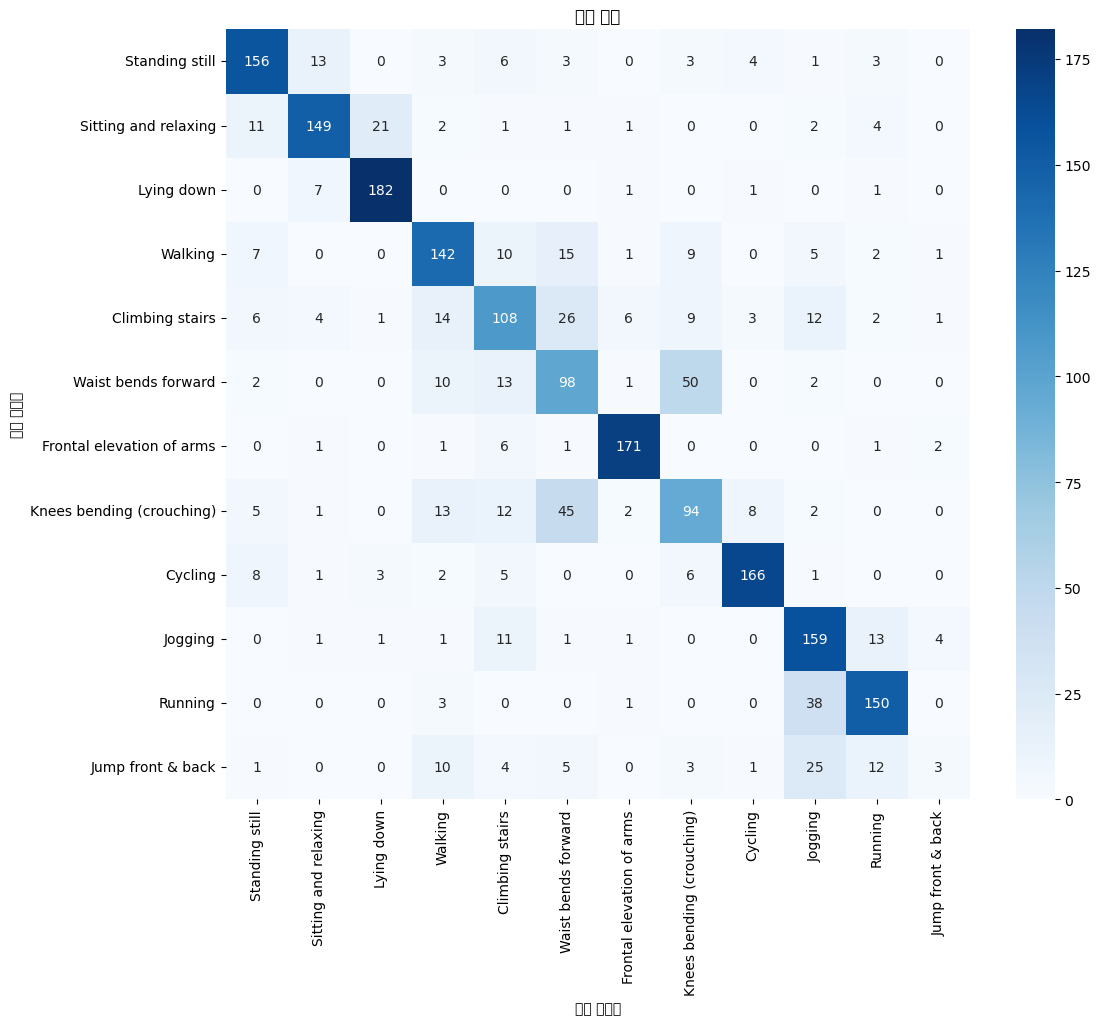

분류 보고서:
                           precision    recall  f1-score   support

           Standing still       0.80      0.81      0.80       192
     Sitting and relaxing       0.84      0.78      0.81       192
               Lying down       0.88      0.95      0.91       192
                  Walking       0.71      0.74      0.72       192
          Climbing stairs       0.61      0.56      0.59       192
      Waist bends forward       0.50      0.56      0.53       176
Frontal elevation of arms       0.92      0.93      0.93       183
Knees bending (crouching)       0.54      0.52      0.53       182
                  Cycling       0.91      0.86      0.89       192
                  Jogging       0.64      0.83      0.72       192
                  Running       0.80      0.78      0.79       192
        Jump front & back       0.27      0.05      0.08        64

                 accuracy                           0.74      2141
                macro avg       0.70      0.70      

In [15]:
# 저장된 모델 로드
model.load_state_dict(torch.load('best_model_mhealth_gyro.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# 혼동 행렬 계산
cm = confusion_matrix(all_labels, all_preds)

# 클래스 이름 정의 (레이블 인덱스와 매칭)
class_names = [
    'Standing still',          # 레이블 0
    'Sitting and relaxing',    # 레이블 1
    'Lying down',              # 레이블 2
    'Walking',                 # 레이블 3
    'Climbing stairs',         # 레이블 4
    'Waist bends forward',     # 레이블 5
    'Frontal elevation of arms', # 레이블 6
    'Knees bending (crouching)', # 레이블 7
    'Cycling',                 # 레이블 8
    'Jogging',                 # 레이블 9
    'Running',                 # 레이블 10
    'Jump front & back'        # 레이블 11
]

# 혼동 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('실제 레이블')
plt.xlabel('예측 레이블')
plt.title('혼동 행렬')
plt.show()

# 분류 보고서 출력
print("분류 보고서:")
print(classification_report(all_labels, all_preds, target_names=class_names))